In [45]:
# Import necessary libraries
import numpy as np
import gym
from gym import spaces
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

In [46]:
# Define Durak Environment (fixed)
class DurakEnv(gym.Env):
    def __init__(self):
        super(DurakEnv, self).__init__()
        
        # Define action and observation space (36 card actions)
        self.action_space = spaces.Discrete(36)  # 36 cards in deck (simplified)
        self.observation_space = spaces.Box(low=0, high=1, shape=(36,), dtype=np.float32)  # 36 cards in the state (1D)
        
        self.deck = self._initialize_deck()
        self.state = self._initialize_state()
        self.done = False
        self.current_player = 0
        
    def _initialize_deck(self):
        """Initialize the card deck for the game"""
        return deque(np.arange(36))  # Simplified deck of 36 cards

    def _initialize_state(self):
        """Initial state representation"""
        return np.zeros(36)  # Simplified state of the game
    
    def reset(self):
        """Reset the game state"""
        self.deck = self._initialize_deck()
        self.state = self._initialize_state()
        self.done = False
        self.current_player = 0
        return self.state

    def step(self, action):
        """Take an action in the environment"""
        if self.done:
            raise Exception("Game over, reset the environment")
        
        # Apply action to update state (simplified logic)
        self.state[action] = 1  
        reward = self._calculate_reward()
        
        # Check if game is done
        self.done = self._check_game_over()
        
        # Switch players after action
        self.current_player = (self.current_player + 1) % 2
        return self.state, reward, self.done, {}
    
    def _calculate_reward(self):
        """Basic reward function"""
        if self._check_game_over():
            return 100 if self.current_player == 0 else -100
        return -1  # Penalty for each step
    
    def _check_game_over(self):
        """Check if the game is over"""
        return np.sum(self.state) >= 6

    def render(self, mode='human'):
        """Render the game state"""
        print(f"Current player: {self.current_player}, State:\n{self.state}")

# Create environment
env = DurakEnv()

In [47]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.999
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
    
    def _build_model(self):
        """Build a simple neural network model"""
        model = nn.Sequential(
            nn.Linear(self.state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size)  # Output should match the action space (36 actions)
        )
        return model
    
    def update_target_model(self):
        """Update target model weights"""
        self.target_model.load_state_dict(self.model.state_dict())
    
    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay memory"""
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        """Return action based on epsilon-greedy policy"""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Action space size is 36
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return np.argmax(act_values.detach().numpy())
    
    def replay(self, batch_size):
        """Train the model using random experiences from memory"""
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state = torch.FloatTensor(next_state).unsqueeze(0)
                target = (reward + self.gamma * torch.max(self.target_model(next_state)).item())
            state = torch.FloatTensor(state).unsqueeze(0)
            target_f = self.model(state)
            target_f[0][action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [48]:
def train_dqn_agent(env, agent, episodes=2000, batch_size=32):
    rewards = []
    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        for time in range(100):  # Maximum 100 steps per episode
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                agent.update_target_model()
                print(f"Episode {e+1}/{episodes} - Reward: {total_reward}, Epsilon: {agent.epsilon}")
                break
            agent.replay(batch_size)
        rewards.append(total_reward)
    return rewards

# Instantiate agent and train
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

rewards = train_dqn_agent(env, agent)

Episode 1/2000 - Reward: -105, Epsilon: 1.0
Episode 2/2000 - Reward: -105, Epsilon: 1.0
Episode 3/2000 - Reward: 94, Epsilon: 1.0
Episode 4/2000 - Reward: -105, Epsilon: 1.0
Episode 5/2000 - Reward: -105, Epsilon: 1.0
Episode 6/2000 - Reward: -105, Epsilon: 0.995009990004999
Episode 7/2000 - Reward: 94, Epsilon: 0.9890548353295385
Episode 8/2000 - Reward: -105, Epsilon: 0.98411944181564
Episode 9/2000 - Reward: -105, Epsilon: 0.9792086759647052
Episode 10/2000 - Reward: -109, Epsilon: 0.9704309672630859
Episode 11/2000 - Reward: -105, Epsilon: 0.9655885070369844
Episode 12/2000 - Reward: 92, Epsilon: 0.9578907814534664
Episode 13/2000 - Reward: -105, Epsilon: 0.9531108968798944
Episode 14/2000 - Reward: 94, Epsilon: 0.9474065091141411
Episode 15/2000 - Reward: -105, Epsilon: 0.9426789411643326
Episode 16/2000 - Reward: -105, Epsilon: 0.9379749638258457
Episode 17/2000 - Reward: -105, Epsilon: 0.933294459381294
Episode 18/2000 - Reward: 94, Epsilon: 0.9277086733900016
Episode 19/2000 - 

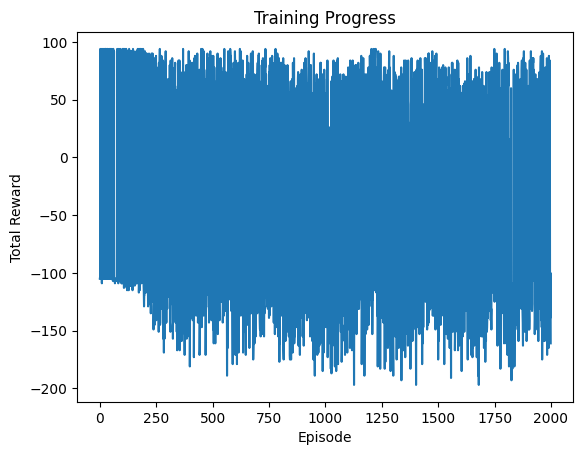

In [49]:
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress")
    plt.show()

plot_rewards(rewards)

In [50]:
def evaluate_dqn_agent(env, agent, episodes=100):
    total_rewards = []
    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            total_reward += reward
        total_rewards.append(total_reward)
    avg_reward = np.mean(total_rewards)
    print(f"Average reward over {episodes} episodes: {avg_reward}")

evaluate_dqn_agent(env, agent)

Average reward over 100 episodes: -46.2


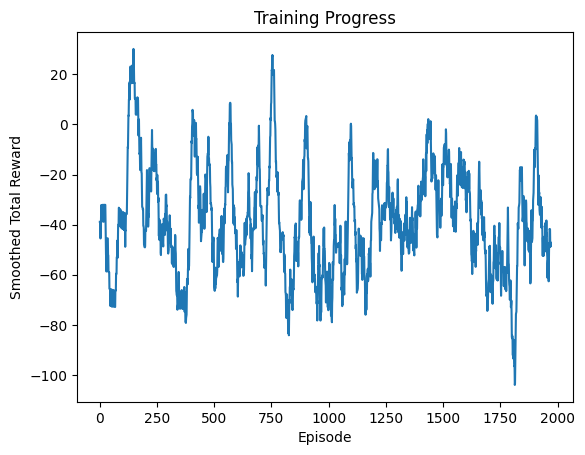

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# rewards = np.array(reward_history)  # Reward per episode
smoothed_rewards = np.convolve(rewards, np.ones(30)/30, mode='valid')  # Moving average over 20 episodes
plt.plot(smoothed_rewards)
plt.xlabel("Episode")
plt.ylabel("Smoothed Total Reward")
plt.title("Training Progress")
plt.show()